# Adapting Mask-RCNN for document segmentation

Mask-RCNN is a flexible, state of the art model for instance segmentation.

<img src="img/iseg.png" width=400 height=400>

(Source: https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)

It is a very simple, but intuitive, extension of the widely successful Faster-RCNN model. Faster-RCNN combines object detection and semantic segmantation to output a bounding box and class for each identafiable object in an image. Mask-RCNN simply adds another branch for mask prediction, which means producing a mask for each bounding box representing which part of the image actually corresponds to the class.

<img src="img/overview.png" width=800 height=400>

We have retrained and tuned Mask-RCNN for the task of document segmentation. In our task, we wish to segment the important regions of each document and classify them. Given our trained weights, lets run inference on a couple of images and see the results.

In [1]:
from mrcnn.config import Config
from PIL import Image, ImageDraw, ImageFont
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from dataset import PageDataset
import numpy as np
from mrcnn import visualize
from tqdm import tqdm
from config import PageConfig
from random import sample
from argparse import ArgumentParser
from voc_utils import ICDAR_convert
import matplotlib.pyplot as plt

# Set paths
data_path = 'data/'
weights_path = 'weights/'

Using TensorFlow backend.


## Configuration setup

In [8]:
class InferenceConfig(Config):
        NAME = "pages"
        BACKBONE = "resnet50"
        GPU_COUNT = 1
        IMAGE_MAX_DIM = 1920
        RPN_ANCHOR_SCALES = (32,64, 256, 512,1024)
        NUM_CLASSES = 5
        IMAGES_PER_GPU = 1

## Some visualization functions (NOTE: You should change the font to some valid font, see comment)

In [14]:
def rect(d, im, color, points):
        for i, pt in enumerate(points[:-1]):
                d.line((pt, points[i+1]), fill=color, width=4)

def draw_rois(d, im, color, rois, cls, down=False):
        for idx, roi in enumerate(rois):
                y1, x1, y2, x2 = roi
                points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
                text_points = (x1 + 10, y1 + 10)
                if down:
                    text_points = (x1 + 50, y1 + 50)
                ks = ['Figure', 'Table', 'Equation', 'Body Text']
                key = ks[cls[idx]-1]
                # Replace the string with some valid font
                d.text(text_points, key, fill=color, font=ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 30, encoding="unic"))
                d.rectangle([x1, y1, x2, y2], outline=color)
                rect(d, im, color, points )

def draw_image(name, path, rois, gt_rois, gt_classes, classes):
        im = Image.open(path)
        d = ImageDraw.Draw(im)
        draw_rois(d, im, "#f00", rois, classes)
        draw_rois(d, im, "#00f", gt_rois, gt_classes, down=True)
        #im.save(f"{name}.png", "png")
        plt.figure(figsize=(20, 20))
        plt.imshow(np.asarray(im), aspect='auto')

## Prepare the model and sample an image

In [21]:
inference_config = InferenceConfig()
config = PageConfig()
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=weights_path)

model_path = model.find_last()

print("Loading weights from ", weights_path)
model.load_weights('weights/pages20181202T1550/mask_rcnn_pages_0020.h5', by_name=True)
data_test = PageDataset('test', data_path, 1)
data_test.load_page(classes=['Figure', 'Table', 'Equation', 'Body Text'])

data_test.prepare()
image_ids = data_test.image_ids

Loading weights from  weights/
Re-starting from epoch 20
loaded 72 images



In [22]:
image_ids = sample(list(image_ids), 1)

## Finally lets run the model on the sample

100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


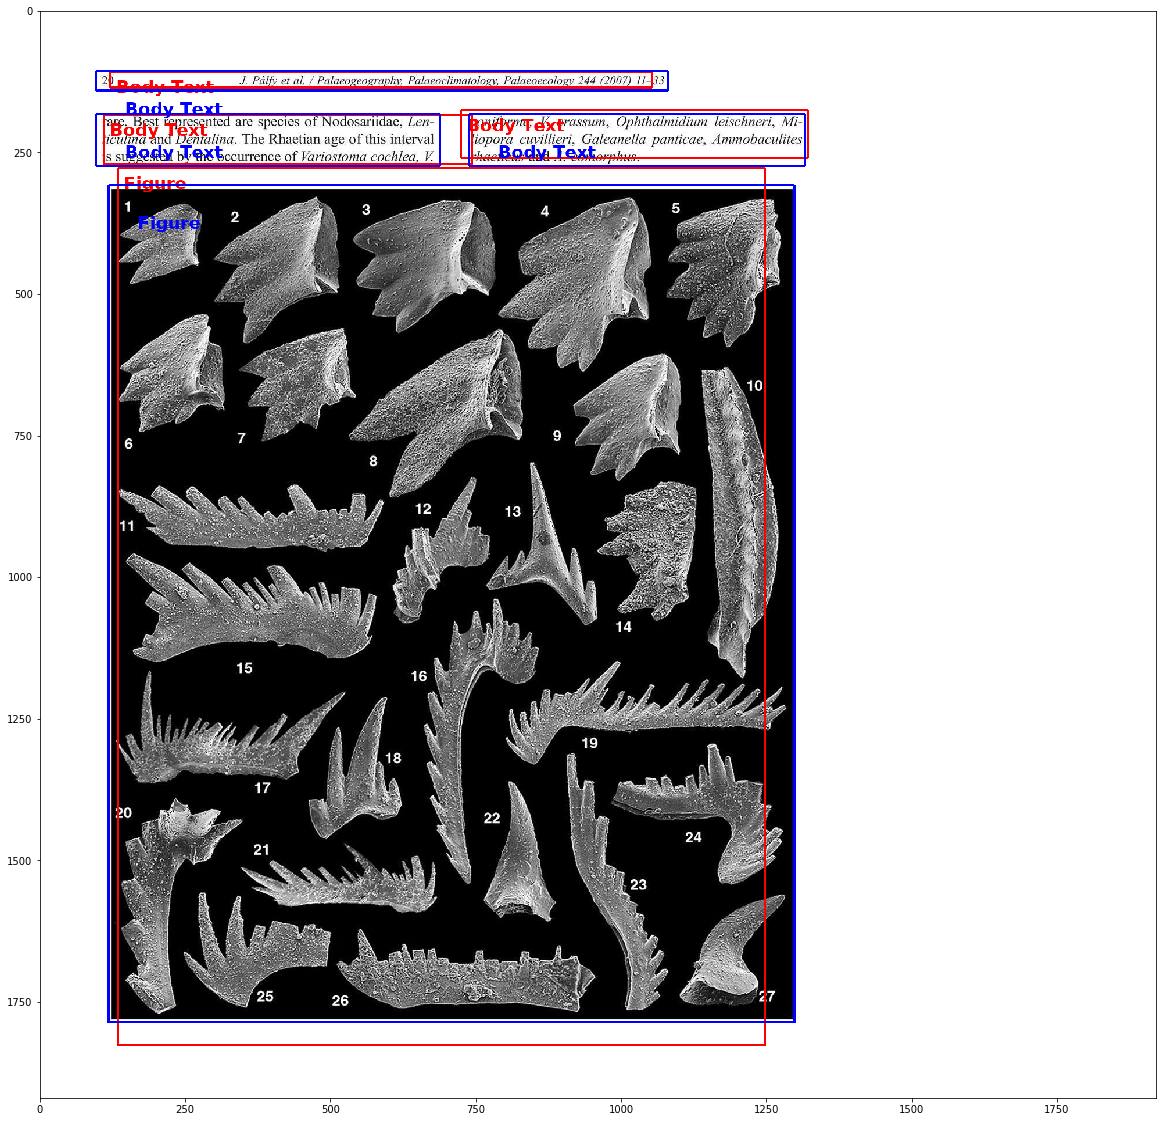

In [23]:
%matplotlib inline
for idx, image_id in enumerate(tqdm(image_ids)):
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(data_test, inference_config,image_id, use_mini_mask=False)
        results = model.detect([image], verbose=0)
        r = results[0]
        #print(r)
        info = data_test.image_info[image_id]
        draw_image(info["str_id"], info["path"], r["rois"], gt_bbox, gt_class_id, r['class_ids'])